In [9]:
import torch 
import torch.nn as nn
import os
import argparse
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import sys
from PIL import Image
import requests
from io import BytesIO
import urllib.request as url_req
import pickle
from Model import get_model
from utils import *
import json
from model_and_data import Data
from targetedFGSM import FGSM_targeted
from targetedBIM import BIM_targeted
from visualize import visualise

In [10]:
# %matplotlib inline
# %matplotlib qt

In [11]:
device  = torch.device('cpu')

In [12]:
model = get_model(device)                  # loads a pretrained vgg11 model
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [13]:
def imshow(img,wnid,title=None):
    img = img.cpu().detach().numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    
    img = img*std+mean
#     img = np.clip(img,0,1)
    plt.imshow(img)
    
#     title = getClassOfId(wnid)
    
    plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [14]:
# url_files = ['valid_urls1.txt','valid_urls2.txt','valid_urls3.txt','valid_urls4.txt','valid_urls5.txt']
# # url_files = ['valid_urls1.txt']
 
# key_to_label_map = pickle.load(open('pickled_id_label_imagenet_map', 'rb')) # load mapping as dict

# for url_file in url_files:
#     with open(url_file) as f:
#         url_dict = json.load(f)
        
#         label_idxs = list(url_dict.keys())
#         print(label_idxs)
#         label = label_idxs[0]
#         key = key_to_label_map[int(label)]['label']
#         print(key,label)
#         url_list = url_dict[label]
#         test_url = url_list[0]
#         test_img = urltoImg(test_url)
        
#         data = Data(model,device, None,None)
#         img_tsor = data.preprocess_data(test_img)
#         img_tsor.unsqueeze_(0)
#         img_tsor = img_tsor.to(device)

#         label = torch.tensor(float(label),requires_grad=False)
#         label = label.to(device)

#         criterion = nn.CrossEntropyLoss()
#         print(img_tsor.size())
#         output = model(img_tsor)
#         _,pred = torch.max(output,1)
#         img_tsor.squeeze_(0)
#         imshow(img_tsor,key)
#         print('Original label = ',float(label))
#         print('Output idx and class =',float(pred.cpu()),',',key_to_label_map[float(pred.cpu())]['label'])


### Save all images

In [15]:
# url_files = ['valid_urls1.txt','valid_urls2.txt','valid_urls3.txt','valid_urls4.txt','valid_urls5.txt']

# for url_file in url_files:
#     with open(url_file) as f:
#         url_dict = json.load(f)
        
#     for label in url_dict.keys():
#         save_imgs(label,url_dict[label])

In [16]:
imgs = os.listdir('imagenet_imgs/')
all_labels = [img_name.split('_')[0] for img_name in imgs]
unique_labels = np.unique(all_labels)
print(unique_labels)



['121' '130' '144' '148' '151' '21' '282' '293' '295' '298' '309' '31'
 '311' '314' '35' '360' '417' '430' '438' '457' '470' '480' '49' '491'
 '63' '75' '8' '84' '86' '9']


In [18]:
imgs = os.listdir('imagenet_imgs/')

# epsilon_arr = list(np.linspace(0,1,21))
# epsilon_arr = [0.01,0.05,0.1,0.5,1]
epsilon_arr = [0.01,0.05]

batch_size = len(os.listdir('imagenet_imgs/'))
fg_top_one_acc_arr = []
fg_top_five_acc_arr = []

fg_t1_local_acc = []             # local is for exact class change
fg_t5_local_acc = []

bim_top_one_acc_arr = []
bim_top_five_acc_arr = []
bim_t1_local_acc = []
bim_t5_local_acc = []

unpert_top_one_acc = []
unpert_top_five_acc = []

top_one_misclassfns = {}
top_five_misclassfns = {}


for epsilon in epsilon_arr:
    top_one_misclassfns['unpert'] = 0
    top_one_misclassfns['fgsm'] = 0
    top_one_misclassfns['fgsm_local'] = 0
    top_one_misclassfns['bim'] = 0
    top_one_misclassfns['bim_local'] = 0
    
    # top_one_misclassfn['llc'] = 0

    top_five_misclassfns['unpert'] = 0
    top_five_misclassfns['fgsm'] = 0
    top_five_misclassfns['fgsm_local'] = 0
    top_five_misclassfns['bim'] = 0
    top_five_misclassfns['bim_local'] = 0
    
    # top_five_misclassfn['llc'] = 0
    
    
    # choose randomly a target class
    targetLabel = unique_labels[np.random.randint(0,len(unique_labels))]
    targetLabel = torch.tensor([int(targetLabel)],requires_grad=False)
    targetLabel = targetLabel.to(device)
    
    for idx,img_name in enumerate(imgs):
            print(idx)
            img_path = os.path.join('imagenet_imgs/',img_name)
            data = Data(model,device, None,None)
            img_tsor = data.preprocess_data(Image.open(img_path))
    #         imshow(img_tsor,'dgs')
            img_tsor.unsqueeze_(0)
            img_tsor = img_tsor.to(device)
            img_tsor.requires_grad_(True)

            label = img_name.split('_')[0]
            label = torch.tensor([int(label)],requires_grad=False)
            label = label.to(device)
    #         print(label.shape)

            criterion = nn.CrossEntropyLoss()
            ############ Unperturbed Model ######################
            unpert_output,unpert_pred, unpert_op_probs, unpert_pred_prob = getPredictionInfo(model,img_tsor)
            unpert_top_probs, unpert_top_labels = predict_top_five(model,img_tsor,k=5)
            
            top_one_misclassfns['unpert'] = checkMatchingLabels(label,unpert_pred,top_one_misclassfns['unpert'])
            top_five_misclassfns['unpert'] = checkMatchingLabelsTop_five(label,unpert_top_labels,top_five_misclassfns['unpert'])
            model.zero_grad()
            ############### FGSM ################################
            
            
            fgsm = FGSM_targeted(model,criterion,img_tsor,label,targetLabel,epsilon)
            fg_adv_img,fg_perturbation = fgsm.attack()
            
            fg_output_adv,fg_pred_adv, fg_op_adv_probs, fg_adv_pred_prob  = getPredictionInfo(model,fg_adv_img)
#             output_adv = model(torch.tensor(adv_img))
#             _,pred_adv = torch.max(output_adv.data,1)
#         #     print(adv_img.data-img.data)
#             op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
#             adv_pred_prob =  ((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)      #find probability (confidence) of a predicted class

            fg_top_probs,fg_top_labels = predict_top_five(model,fg_adv_img,k=5)

    #         print(int(label),int(pred_adv))
            top_one_misclassfns['fgsm'] = checkMatchingLabels(label,fg_pred_adv,top_one_misclassfns['fgsm'])
            top_five_misclassfns['fgsm'] = checkMatchingLabelsTop_five(label,fg_top_labels,top_five_misclassfns['fgsm'])
            
            top_one_misclassfns['fgsm_local'] = checkMatchingLabels(targetLabel,fg_pred_adv,top_one_misclassfns['fgsm_local'])
            top_five_misclassfns['fgsm_local'] = checkMatchingLabelsTop_five(targetLabel,fg_top_labels,top_five_misclassfns['fgsm_local'])
            
            model.zero_grad()
            ################ BIM ##############################
            bim = BIM_targeted(model,criterion,img_tsor,label,targetLabel,epsilon,epsilon/2,num_iters=0,random_state=False)
            
            bim_adv_img,bim_perturbation,bim_loss = bim.attack()
            
            bim_output_adv,bim_pred_adv, bim_op_adv_probs, bim_adv_pred_prob  = getPredictionInfo(model,bim_adv_img)
            
            bim_top_probs,bim_top_labels = predict_top_five(model,bim_adv_img,k=5)


            top_one_misclassfns['bim'] = checkMatchingLabels(label,bim_pred_adv,top_one_misclassfns['bim'])
            top_five_misclassfns['bim'] = checkMatchingLabelsTop_five(label,bim_top_labels,top_five_misclassfns['bim'])
            
            top_one_misclassfns['bim_local'] = checkMatchingLabels(targetLabel,bim_pred_adv,top_one_misclassfns['bim_local'])
            top_five_misclassfns['bim_local'] = checkMatchingLabelsTop_five(targetLabel,bim_top_labels,top_five_misclassfns['bim_local'])
            model.zero_grad()
            
            

                
    unpert_top_one_acc.append(1-(top_one_misclassfns['unpert']/batch_size))
    unpert_top_five_acc.append(1-(top_five_misclassfns['unpert']/batch_size))
    fg_top_one_acc_arr.append(1-(top_one_misclassfns['fgsm']/batch_size))
    fg_top_five_acc_arr.append(1-(top_five_misclassfns['fgsm']/batch_size))
    fg_t1_local_acc.append(1-(top_one_misclassfns['fgsm_local']/batch_size))
    fg_t5_local_acc.append(1-(top_five_misclassfns['fgsm_local']/batch_size))
    bim_top_one_acc_arr.append(1-(top_one_misclassfns['bim']/batch_size))
    bim_top_five_acc_arr.append(1-(top_five_misclassfns['bim']/batch_size))
    bim_t1_local_acc.append(1-(top_one_misclassfns['bim_local']/batch_size))
    bim_t5_local_acc.append(1-(top_five_misclassfns['bim_local']/batch_size))
    
    print('Unpert Top 1 Accuracy :',1-(top_one_misclassfns['unpert']/batch_size))
    print('Unpert Top 5 Accuracy :',1-(top_five_misclassfns['unpert']/batch_size))
    print('Top 1 FGSM Accuracy :',1-(top_one_misclassfns['fgsm']/batch_size))
    print('Top 5 FGSM Accuracy :',1-(top_five_misclassfns['fgsm']/batch_size))
    print('Top 1 FGSM Accuracy(Class Changed) :',1-(top_one_misclassfns['fgsm_local']/batch_size))
    print('Top 5 FGSM Accuracy(Class Changed) :',1-(top_five_misclassfns['fgsm_local']/batch_size))
    print('Top 1 BIM Accuracy :',1-(top_one_misclassfns['bim']/batch_size))
    print('Top 5 BIM Accuracy :',1-(top_five_misclassfns['bim']/batch_size))
    print('Top 1 BIM Accuracy(Class Changed) :',1-(top_one_misclassfns['bim_local']/batch_size))
    print('Top 5 BIM Accuracy(Class Changed) :',1-(top_five_misclassfns['bim_local']/batch_size))
    
    

# plt.figure()
# plt.title('Top-1 Accuracy for FGSM and BIM vs Epsilon')
# plt.plot(epsilon_arr,unpert_top_one_acc, label='Unperturbed Model')
# plt.plot(epsilon_arr,fg_top_one_acc_arr,label='FGSM')
# plt.plot(epsilon_arr,bim_top_one_acc_arr,label='BIM')
# plt.ylabel('Top-1 Accuracy')
# plt.xlabel('Epsilon')
# plt.legend()


# plt.figure()
# plt.title('Top-5 Accuracy for FGSM and BIM vs Epsilon')
# plt.plot(epsilon_arr,unpert_top_five_acc)
# plt.plot(epsilon_arr,top_five_acc_arr,label='FGSM')
# plt.plot(epsilon_arr,bim_top_five_acc_arr,label='BIM')
# plt.ylabel('Top-5 Accuracy')
# plt.xlabel('Epsilon')
# plt.legend()
# plt.show()
# #         visualise(img_tsor,perturbation,adv_img,label,label,pred_prob,pred_adv,adv_pred_prob,epsilon,topkProb=top_probs,topkLabel=top_labels)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
Unpert Top 1 Accuracy : 1.0
Unpert Top 5 Accuracy : 1.0
Top 1 FGSM Accuracy : 0.5733333333333333
Top 5 FGSM Accuracy : 0.7866666666666666
Top 1 FGSM Accuracy(Class Changed) : 0.06000000000000005
Top 5 FGSM Accuracy(Class Changed) : 0.10666666666666669
Top 1 BIM Accuracy : 0.9466666666666667
Top 5 BIM Accuracy : 1.0
Top 1 BIM Accuracy(Class Changed) : 0.94
Top 5 BIM Accuracy(Class Changed) : 0.033333333333333326
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


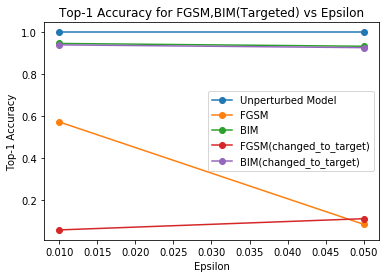

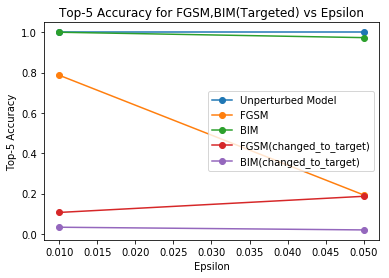

Epsilon [0.01, 0.05]
Unperturbed
[1.0, 1.0]
[1.0, 1.0]
FGSM
[0.5733333333333333, 0.08666666666666667]
[0.7866666666666666, 0.19333333333333336]
BIM
[0.9466666666666667, 0.9333333333333333]
[1.0, 0.9733333333333334]
FGSM_local
[0.06000000000000005, 0.11333333333333329]
[0.10666666666666669, 0.18666666666666665]
BIM_local
[0.94, 0.9266666666666666]
[0.033333333333333326, 0.020000000000000018]
DONE DONA DONE


In [19]:
# epsilon_arr = [0.05]
plt.figure()
plt.title('Top-1 Accuracy for FGSM,BIM(Targeted) vs Epsilon')
plt.plot(epsilon_arr,unpert_top_one_acc, label='Unperturbed Model',marker='o')
plt.plot(epsilon_arr,fg_top_one_acc_arr,label='FGSM',marker='o')
plt.plot(epsilon_arr,bim_top_one_acc_arr,label='BIM',marker='o')
plt.plot(epsilon_arr,fg_t1_local_acc,label='FGSM(changed_to_target)',marker='o')
plt.plot(epsilon_arr,bim_t1_local_acc,label='BIM(changed_to_target)',marker='o')
plt.ylabel('Top-1 Accuracy')
plt.xlabel('Epsilon')
plt.legend()


plt.figure()
plt.title('Top-5 Accuracy for FGSM,BIM(Targeted) vs Epsilon')
plt.plot(epsilon_arr,unpert_top_five_acc,label='Unperturbed Model',marker='o')
plt.plot(epsilon_arr,fg_top_five_acc_arr,label='FGSM',marker='o')
plt.plot(epsilon_arr,bim_top_five_acc_arr,label='BIM',marker='o')
plt.plot(epsilon_arr,fg_t5_local_acc,label='FGSM(changed_to_target)',marker='o')
plt.plot(epsilon_arr,bim_t5_local_acc,label='BIM(changed_to_target)',marker='o')
plt.ylabel('Top-5 Accuracy')
plt.xlabel('Epsilon')
plt.legend()
plt.show()
#         visualise(img_tsor,perturbation,adv_img,label,label,pred_prob,pred_adv,adv_pred_prob,epsilon,topkProb=top_probs,topkLabel=top_labels)
print('Epsilon',epsilon_arr)
print('Unperturbed')
print(unpert_top_one_acc)
print(unpert_top_five_acc)
print('FGSM')
print(fg_top_one_acc_arr)
print(fg_top_five_acc_arr)
print('BIM')
print(bim_top_one_acc_arr)
print(bim_top_five_acc_arr)
print('FGSM_local')
print(fg_t1_local_acc)
print(fg_t5_local_acc)
print('BIM_local')
print(bim_t1_local_acc)
print(bim_t5_local_acc)
print('DONE DONA DONE')